Introduction
-------------

PRISM [1] provides precipitation data based on location, as far back as 1981.
This dataset was generated with the parameters:
* Location:  Lat: 35.5515   Lon: -97.4072   Elev: 1171ft
* Climate variables: ppt,tmin,tmean,tmax,tdmean,vpdmin,vpdmax
* Spatial resolution: 4km
* Period: 1981-01-01 - 2022-12-31
* Dataset: AN91d
* PRISM day definition: 24 hours ending at 1200 UTC on the day shown
* Grid Cell Interpolation: Off

This notebook is intended to demo the data analysis and data modelling process as a part of a portfolio. The ultimate goal is to be able to predict total precipitation (rain + melted snow). 

Feature Explanation
----------------------

| Name   | Description                                                                                                           | Units |
| ------ | --------------------------------------------------------------------------------------------------------------------- | ----- |
| ppt    | Total precipitation (rain+melted snow) for the day                                                                    | in    |
| tmin   | Minimum temperature for the day                                                                                       | F     |
| tmean  | Mean temperature for the day (tmax+tmin)/2                                                                            | F     |
| tmax   | Maximum temperature for the day                                                                                       | F     |
| tdmean | Mean dewpoint temperature (analogous to humidity and comfort)                                                         | F     |
| vpdmin | Minimum difference between the amount of vapor in the air, versus the total amount it can hold (relative to humidity) | hPa   |
| vpdmax | Maximum difference between the amount of vapor in the air, versus the total amount it can hold (relative to humidity) | hPa   |

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, log_loss, roc_curve, auc, accuracy_score, mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, LogisticRegression
from math import dist
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\asaph\\Documents\\projects\\ok_rain_regression\\utils.py'>

In [35]:
"""
First thing we want to do is read in the dataframe,
clean up the column names and move them in the order
that we want. We also want to decode the date and
extract the information from it.
"""
df = pd.read_csv("prism_ok_country_precip_data.csv")
col_names = ["date","precip","min_temp","mean_temp","max_temp","dewpoint","vpd_min","vpd_max"]
df.columns = col_names
df.loc[:,"year"] = pd.DatetimeIndex(df["date"]).year
df.loc[:,"month"] = pd.DatetimeIndex(df["date"]).month
df.loc[:,"day"] = pd.DatetimeIndex(df["date"]).day
df.loc[:,"jul_day"] = pd.DatetimeIndex(df["date"]).dayofyear
col_order = ["year","month","day","jul_day","min_temp","mean_temp","max_temp","dewpoint","vpd_min","vpd_max","precip"]
df = df.loc[:,col_order]
print(df)
df.info()
df.to_csv("rain.csv", index=False)

       year  month  day  jul_day  min_temp  mean_temp  max_temp  dewpoint  \
0      1981      1    1        1      36.8       49.6      62.5      30.2   
1      1981      1    2        2      28.0       41.6      55.2      24.4   
2      1981      1    3        3      26.2       40.7      55.1      27.5   
3      1981      1    4        4      20.0       33.0      45.9      22.1   
4      1981      1    5        5      20.2       31.0      41.9      14.8   
...     ...    ...  ...      ...       ...        ...       ...       ...   
15335  2022     12   27      361      16.2       31.2      46.1      16.3   
15336  2022     12   28      362      18.1       34.5      50.9      21.2   
15337  2022     12   29      363      43.8       55.8      67.9      39.0   
15338  2022     12   30      364      34.3       50.3      66.3      32.1   
15339  2022     12   31      365      31.1       44.0      56.8      33.3   

       vpd_min  vpd_max  precip  
0         2.10    13.32     0.0  
1      

Date
1983-10-20    5.51
1987-05-28    4.23
2007-08-19    4.48
2010-06-15    6.16
2013-06-01    7.11
2021-06-27    5.38
Name: ppt (inches), dtype: float64
Days w/ >= 1.0 in rain: 409
Days w/ >= 2.0 in rain: 87
Days w/ >= 3.0 in rain: 21


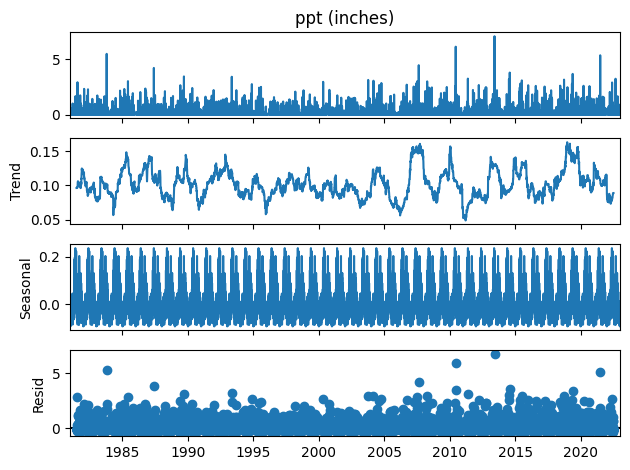

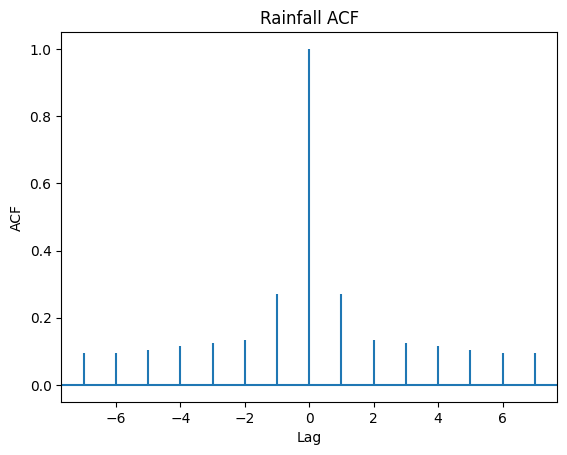

In [54]:
"""
We can time series decompose the actual
precipitation data by itself. This will
give us a good idea of the overall rainfall
behavior over the time that we have. We can
draw some conclusions right away, as this
data has no noise and no missing values.
"""
df = pd.read_csv("prism_ok_country_precip_data.csv")
ts_df = df.loc[:,"ppt (inches)"]
ts_df.index = pd.DatetimeIndex(df["Date"])
ts = seasonal_decompose(ts_df, period=365)
print(ts_df[ts_df >= 4.0])
for val in [1.0,2.0,3.0]:
    count = ts_df[ts_df >= val].shape[0]
    print(f"Days w/ >= {val} in rain: {count}")
ts.plot()
plt.show()
plt.acorr(df["ppt (inches)"].to_numpy(), maxlags=7) # max lag of a week
plt.title("Rainfall ACF")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

Time Series Analysis
======================
First, in the observed plot (top plot of the TS decomp) we see a few significant spikes in recent history. Starting in 2010, then again in 2013 and 2021. These years all had days with 5+ inches of rain in a single day. Within our dataset, there is only one other insance of this which was in 1983. That is a 27 year gap between the first two instances and only 11 years for the next three combined. Even if we look at days with 4+ inches of rain, there was an occurrence in 1987 and the next one was not until 2007; this is still a 20 year gap. This phenomena could indicate a recent increase in days with extreme rainfall in the last 15 years. The last three occurrences all happened in June, which is in the middle of tornado season. Tornado season is often accompanied by floods, which is why the values are so high.
\
\
The trend graph seems to imply a similar behavior. We see a lot of high amplitude changes from about 1984 to 1996. From about 1996 to 2006 we see much smaller changes, an almost flat line considering the y-scale. Then from about 2006 to the present we see another set or high amplitude changes. This might indicate a broader trend of 10-15 years of highly variable rainfall, followed by 8-10 years of stable rainfall and then it repeats. We would need maybe another 20 years of data to confidently point out this trend though. If the trend is true, we are currently (in 2024) 3 years into an 8-10 year period of stable rainfall. This could be useful information to farmers, for example, as they could rotate crops based on water demands accordingly.
\
\
Finally, the  autocorrelation function (ACF) plot tells us something about how rainfall in Oklahoma county is dependent on the previous days. In the plot, we can see significant components (about 0.3) of correlation with a lag of 1 day and then a sharp dropoff from there. In other words, about 30% of the variance in daily rainfall in Oklahoma County can be explained by whether it rained the previous day. This means that the answer to the question "How much rain will we get today?" has some dependence on how much rain we got yesterday, but little depence on how much rain we got two days ago or the days before that. This is useful information for anyone that is interested in forecasting precipitation totals in OK County.

In [37]:
"""
Now we can start to look at the condition of the
data, as well as some descriptive stats.
"""
df = pd.read_csv("rain.csv")
print(df.describe())

               year         month           day       jul_day      min_temp  \
count  15340.000000  15340.000000  15340.000000  15340.000000  15340.000000   
mean    2001.500326      6.523077     15.729205    183.119296     50.128038   
std       12.120919      3.448775      8.800196    105.438628     17.919648   
min     1981.000000      1.000000      1.000000      1.000000    -10.800000   
25%     1991.000000      4.000000      8.000000     92.000000     35.500000   
50%     2001.500000      7.000000     16.000000    183.000000     50.900000   
75%     2012.000000     10.000000     23.000000    274.000000     66.400000   
max     2022.000000     12.000000     31.000000    366.000000     85.900000   

          mean_temp      max_temp      dewpoint       vpd_min       vpd_max  \
count  15340.000000  15340.000000  15340.000000  15340.000000  15340.000000   
mean      60.747106     71.371076     47.666173      2.192583     17.431450   
std       17.958043     18.687281     17.427147    

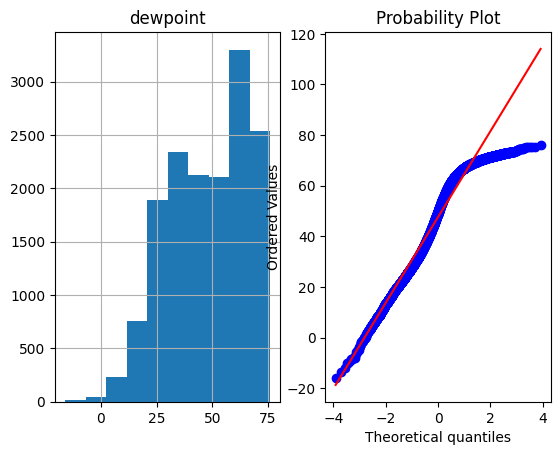

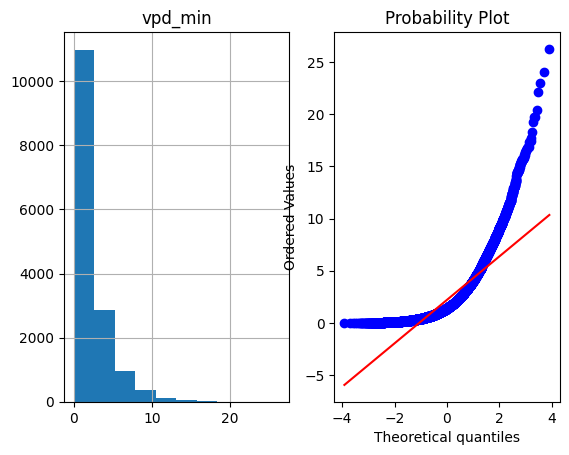

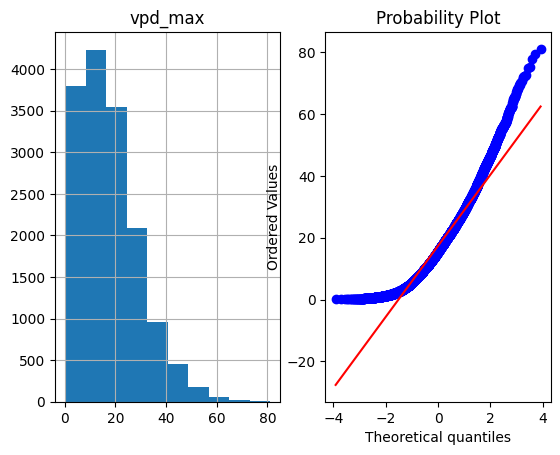

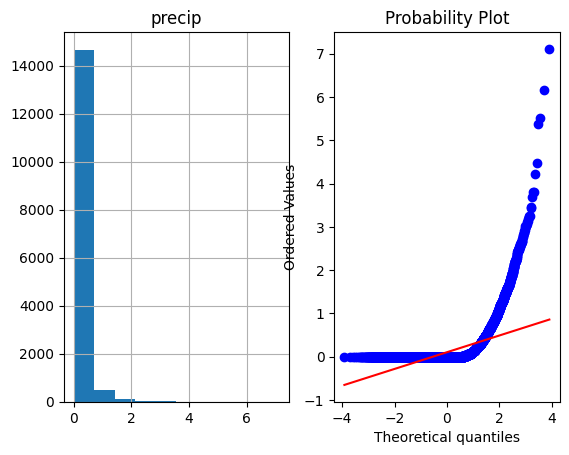

In [40]:
"""
We can see the temperatures seem to be within reasonable ranges.
This information is for Oklahoma County and as a resident I can
use subject knowledge to say that the temperatures are within
reason. If any outliers are present, they are not errors and are
true data points that happen to be outliers.

The dewpoint and VPD min/max are something I do not have subject
knowledge of. So we will take a closer look at these to see the
spreads.

We can also see from the quantiles that the precipitation is
right-skewed and there may be some high outliers. We are not
concerned about fixing the skew, as this is our target 
variable, but we need to make concious choices when splitting
the data.
"""
df = pd.read_csv("rain.csv")
cols = ["dewpoint","vpd_min","vpd_max","precip"]

for c in cols:
    utils.hist_prob_plots(df, c)

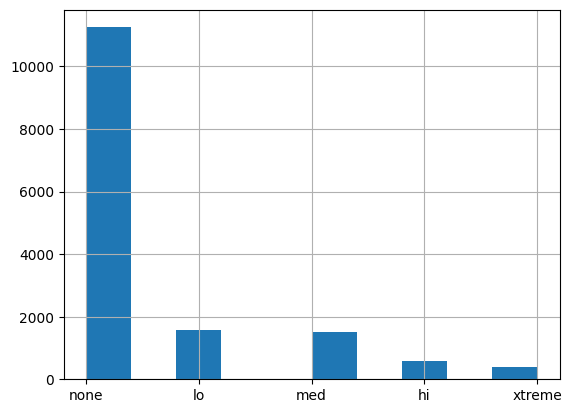

In [39]:
"""
As expected, these values are skewed and have outliers.
First, we will handle the target variable. We will
create a new "meta-target" that will classify the precip
into "none","lo","med","hi" and "xtreme". This will give
us reference points to use when splitting our dataset.
"""
def label_col(df, ranges, col):
    colname = f"{col}_level"
    df.loc[:,colname] = np.full(shape=(df.shape[0],), fill_value="")
    for label in ranges:
        lb = ranges[label][0]
        ub = ranges[label][1]
        df.loc[(df[col] > lb) & (df[col] <= ub),colname] = label
    return df

ranges = {"none": [-np.inf,0.0],
          "lo": [0.0,0.1],
          "med": [0.1,0.5],
          "hi": [0.5,1.0],
          "xtreme": [1.0,np.inf]}

df = label_col(df, ranges, "precip")
df["precip_level"].hist()
plt.show()
df.to_csv("rain.csv", index=False)

               year     month       day   jul_day  min_temp  mean_temp  \
max_temp   0.026951  0.176170  0.017423  0.174323  0.925054   0.981874   
month     -0.000035  1.000000  0.010587  0.996501  0.196428   0.189763   
jul_day    0.000047  0.996501  0.093836  1.000000  0.194020   0.187601   
day        0.000041  0.010587  1.000000  0.093836  0.014043   0.016090   
year       1.000000 -0.000035  0.000041  0.000047 -0.013573   0.007093   
mean_temp  0.007093  0.189763  0.016090  0.187601  0.980272   1.000000   
min_temp  -0.013573  0.196428  0.014043  0.194020  1.000000   0.980272   
vpd_max    0.023122  0.128623  0.017041  0.127642  0.723500   0.806663   
dewpoint   0.013675  0.200274  0.014945  0.198062  0.952217   0.929543   
vpd_min   -0.101580  0.085670  0.015131  0.085218  0.557249   0.585254   
precip    -0.016478  0.004935  0.007181  0.005025  0.105728   0.052575   

           max_temp  dewpoint   vpd_min   vpd_max    precip  
max_temp   1.000000  0.873350  0.590427  0.856518

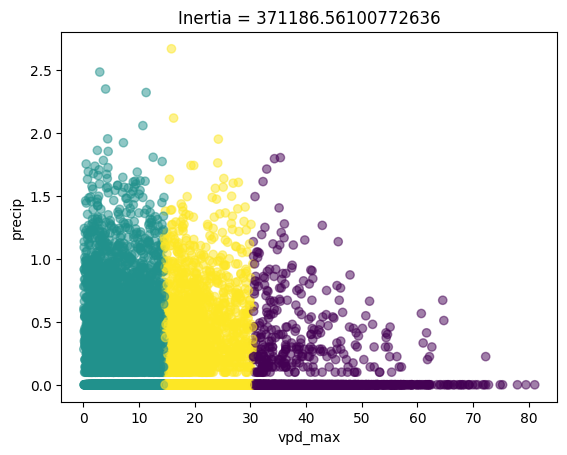

[[ 0.0654712  39.51788321]
 [ 0.18338711  7.69479717]
 [ 0.10184634 21.48875308]]


In [41]:
"""
We can also do some cluster analysis to see if there is
a better way to split the precip totals. In this case
I will take the precip totals and some other feature.
Taking the square root of precip to increase linear
relationship.
"""
df = pd.read_csv("rain.csv")
df.loc[:,"precip"] = np.sqrt(df["precip"].to_numpy())
print(df.iloc[:,:-1].corr().sort_values("precip", key=abs))
x1 = "precip"
x2 = "vpd_max"
cols = [x1, x2]
utils.gen_clusters_and_plot(df, x1, x2, n_clusters=3)

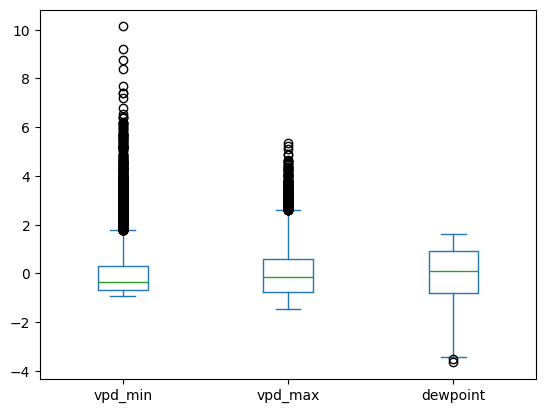

In [42]:
"""
We can see that although these clusters do not give
us an objectively better split of precipitation totals,
they do sort of give us a "potential" for precipitation.
That is, the information within each cluster seems to
give us a potential ceiling for precipitation, given
the value of the other variable being used.

Next we will take a look at the other features which had skew.
"""
df = pd.read_csv("rain.csv")
cols = ["vpd_min","vpd_max","dewpoint"]
df.loc[:,cols] = StandardScaler().fit_transform(df[cols])
df[cols].plot(kind="box")
plt.show()

In [43]:
"""
We can see dewpoint likely has some low outliers,
but these are not too far out. We can try to do
a transformation to attempt to make it more normal
later. The next focus will be vpd_min and vpd_max
because we see these have a lot of high outliers.
The first thing we should do is explore those
outliers and see if they also correspond to precip
outliers.
"""
def check_outlier_dist(df, col, low=False):
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1
    if low:
        cutoff = q1 - (1.5*iqr)
        data = df[df[col] < cutoff]
    else:
        cutoff = q3 + (1.5*iqr)
        data = df[df[col] > cutoff]
    print(f"{col} outlier cutoff = {cutoff}")
    print(data["precip"].describe())

df = pd.read_csv("rain.csv")
check_outlier_dist(df, "vpd_min")
check_outlier_dist(df, "vpd_max")

vpd_min outlier cutoff = 6.385
count    994.000000
mean       0.007575
std        0.039639
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.520000
Name: precip, dtype: float64
vpd_max outlier cutoff = 48.098749999999995
count    285.000000
mean       0.016421
std        0.059028
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.450000
Name: precip, dtype: float64


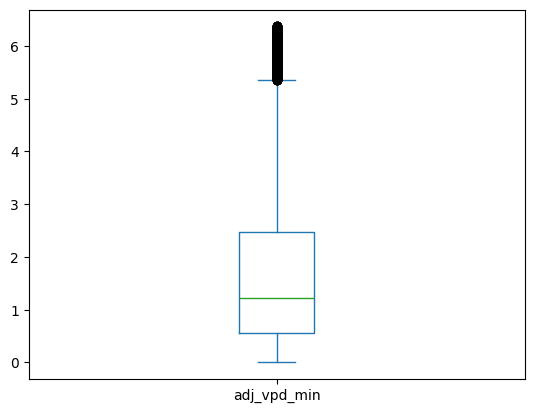

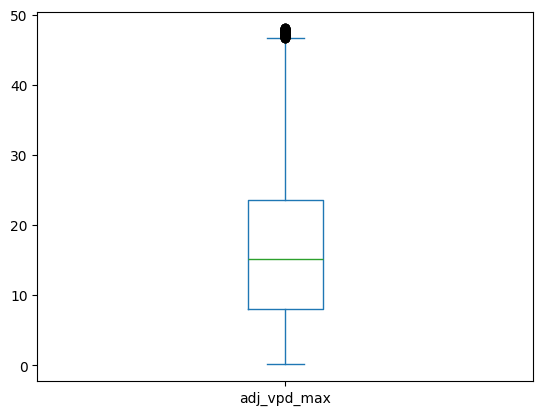

max_temp      -0.000343
month          0.004935
jul_day        0.005025
day            0.007181
year          -0.016478
mean_temp      0.052575
min_temp       0.105728
adj_vpd_max   -0.176778
vpd_max       -0.181124
dewpoint       0.203955
vpd_min       -0.234445
adj_vpd_min   -0.242097
precip         1.000000
Name: precip, dtype: float64


In [44]:
"""
For both vpd_min and vpd_max, the high outliers
correspond to low values of precipitation. This
was also observed in the cluter analysis. I have
no reason to believe that these values were recording
errors, as I don't have subject knowledge. I believe
the best thing to do in this case is to redistribute
these outliers by sampling the inlier distribution
with precipitation in the same range. However, since
we don't know if the outliers are actually part of
the data or not, we will not replace the original
columns.  We will instead make new features called
adj_vpd_min and adj_vpd_max accordingly.
"""
def resample_outliers(df, col, lb, ub, target, target_lb, target_ub):
    new_col = f"adj_{col}"
    inliers = df[(df[col] >= lb) & (df[col] <= ub)]
    sample = inliers.loc[(inliers[target] > target_lb) & (inliers[target] < target_ub),col].to_numpy()
    indexes = list(df[(df[col] < lb) | (df[col] > ub)].index)
    df.loc[:,new_col] = df[col].to_numpy()
    for idx in indexes:
        df.loc[idx,new_col] = np.random.choice(sample)
    return df

df = pd.read_csv("rain.csv")
cols = ["vpd_min","vpd_max"]
new_cols = ["adj_vpd_min","adj_vpd_max"]
df = resample_outliers(df, cols[0], -np.inf, 6.385, "precip", 0.0, 0.52)
df = resample_outliers(df, cols[1], -np.inf, 48.0987, "precip", 0.0, 0.45)
for c in new_cols:
    df[c].plot(kind="box")
    plt.show()
df.to_csv("rain.csv", index=False)
df["precip"] = np.sqrt(df["precip"])
print(df.loc[:, df.columns != "precip_level"].corr().sort_values("precip", key=abs)["precip"])

In [45]:
"""
We can see that the adjusted vpd max had a very small negative effect. 
However, the adjusted vpd min had a small positive effect.

Next, we can do some feature engineering, like adding new columns
based on interactions and transforming other columns as needed.
"""
def transform_target(df, target):
    df.loc[:,f"log_{target}"] = np.log(np.add(df[target].to_numpy(), df[target].min()+1.0))
    df.loc[:,f"sqrt_{target}"] = np.sqrt(df[target].to_numpy())
    df.loc[:,f"{target}^2"] = df[target]*df[target]
    df.loc[:,f"inv_{target}"] = np.divide(1, np.add(df[target].to_numpy(), df[target].min()+1.0))
    return df.columns.values[-4:]

def generate_temporal_features(df):
    df.loc[:, "abs_year"] = df["year"] - df["year"].min()
    df.loc[:, "abs_day"] = (df["abs_year"]*365.25) + df["jul_day"]
    df.loc[:, "abs_week"] = df["abs_day"] / 7.0
    df.loc[:, "abs_month"] = (df["abs_year"]*12.0) + df["month"]
    df.loc[:, "quarter"] = (df["month"] // 3.0) + 1.0
    df.loc[:, "abs_quarter"] = (df["abs_year"]*4.0) + df["quarter"]
    df.loc[:, "day_in_quarter"] = df["jul_day"] % 91

def generate_lag_features(df, cols):
    lag_df = df.iloc[:-1,:].copy()
    lag_df.loc[-1] = df.iloc[0,:].to_numpy()
    lag_df.index = lag_df.index + 1
    lag_df.sort_index(inplace=True) 
    new_cols = {f"prev_{c}": lag_df.loc[:,c] for c in cols}
    new_cols = pd.DataFrame(new_cols)
    return pd.concat([new_cols,df], axis=1)

df = pd.read_csv("rain.csv")
df.loc[:, "vpd_mean"] = (df["vpd_min"] + df["vpd_max"]) / 2.0
df.loc[:, "vpd_range"] = df["vpd_max"] - df["vpd_min"]
dp_offset = abs(df["dewpoint"].min()) + 1.0
df.loc[:, "vapor_dew_ratio"] = df["vpd_mean"] / (df["dewpoint"] + dp_offset)
generate_temporal_features(df)
new_cols = transform_target(df, "precip")
targets = ["precip"] + list(new_cols)
lag_cols = ["min_temp","mean_temp","max_temp","dewpoint","vpd_min",
            "vpd_max","adj_vpd_min","adj_vpd_max","vpd_mean","vpd_range",
            "vapor_dew_ratio"]
df = generate_lag_features(df, lag_cols)
print(df.loc[:, df.columns != "precip_level"].corr().sort_values("precip", key=abs)[targets])
df.to_csv("rain.csv", index=False)

                        precip  log_precip  sqrt_precip  precip^2  inv_precip
abs_year              0.004550   -0.005717    -0.016478  0.019549    0.014019
year                  0.004550   -0.005717    -0.016478  0.019549    0.014019
abs_month             0.004743   -0.005535    -0.016356  0.019691    0.013862
abs_day               0.004754   -0.005526    -0.016354  0.019696    0.013855
abs_week              0.004754   -0.005526    -0.016354  0.019696    0.013855
abs_quarter           0.004807   -0.005476    -0.016316  0.019757    0.013807
prev_adj_vpd_min     -0.004907   -0.012187    -0.025143  0.008278    0.017885
prev_adj_vpd_max     -0.005591   -0.011425    -0.023011  0.005194    0.016021
month                 0.008204    0.007570     0.004935  0.006246   -0.006477
jul_day               0.008634    0.007952     0.005025  0.006405   -0.006739
quarter               0.010368    0.009561     0.006285  0.008592   -0.008315
day                   0.011067    0.010726     0.007181  0.00583

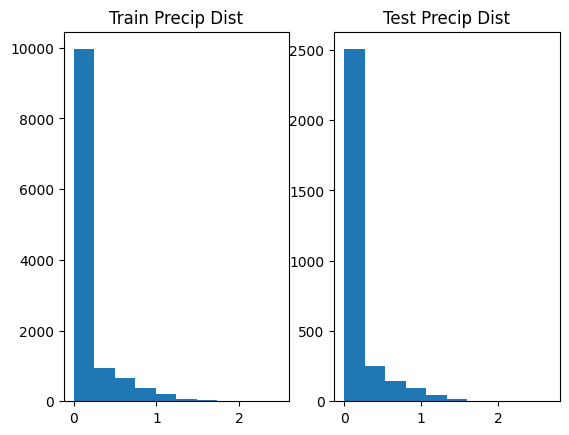

In [46]:
"""
The x_cols were selected based on correlation. The last two columns
were selected because they are the highest correlated temperature
and time columns respectively. Otherwise the input would be solely
based on VPD and dewpoint, which are both analogous to humidity. Later
on we may drop these columns, if we find that they are not important.

Based on the correlation output, all of these features are more linearly
correlated to sqrt_precip. In this case, I chose to transform the
output for modelling. When looking at outputs as actualy future
predictions, we can simply square the prediction to get back to
the units of inches.
"""
x_cols = ['vpd_min', 'vapor_dew_ratio', 'dewpoint', 'prev_dewpoint', 
          'vpd_mean', 'vpd_max', 'prev_min_temp', 'day_in_quarter']
target = "sqrt_precip"
df = pd.read_csv("rain.csv")
df.loc[:,x_cols] = StandardScaler().fit_transform(df[x_cols])
x_train, x_test, y_train, y_test = train_test_split(df[x_cols], df[target], test_size=0.2, 
                                                    stratify=df["precip_level"], random_state=123)

# verifying the distribution of precip
plt.subplot(1,2,1)
plt.hist(y_train)
plt.title("Train Precip Dist")
plt.subplot(1,2,2)
plt.hist(y_test)
plt.title("Test Precip Dist")
plt.show()

{'fit_intercept': True, 'positive': False}
Val score = 0.06623178634230031, Test score = 0.25829687306159255


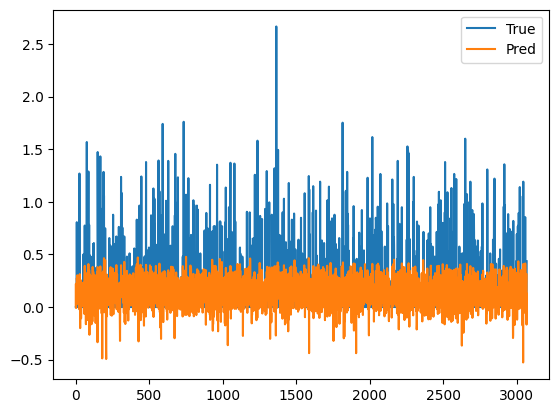

In [47]:
"""
Although skewed, the distribution of targets is the same for
train and test sets.

Now we can do some model tuning. We will start with a simple
OLS model to see how well it works.
"""
def fit_and_eval_model(x_train, y_train, x_test, y_test, model, params):
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1, 
                    scoring="neg_mean_squared_error")
    grid.fit(x_train, y_train)
    print(grid.best_params_)
    lm = grid.best_estimator_
    y_pred = lm.predict(x_test)
    test_err = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Val score = {-1.0*grid.best_score_}, Test score = {test_err}")
    x = list(range(y_test.shape[0]))
    plt.plot(x, y_test, label="True")
    plt.plot(x, y_pred, label="Pred")
    plt.legend()
    plt.show()
    return lm, grid.best_params_

paramset = {"fit_intercept": [False,True], "positive": [False,True]}
lm, params = fit_and_eval_model(x_train, y_train, x_test, y_test, 
                                LinearRegression(), paramset)

Samples without precip 252
Samples with precip 3815
vpd_min           -0.202850
vapor_dew_ratio   -0.171652
dewpoint           0.194477
vpd_max           -0.096901
min_temp           0.117303
month              0.010813
precip             1.000000
Name: precip, dtype: float64


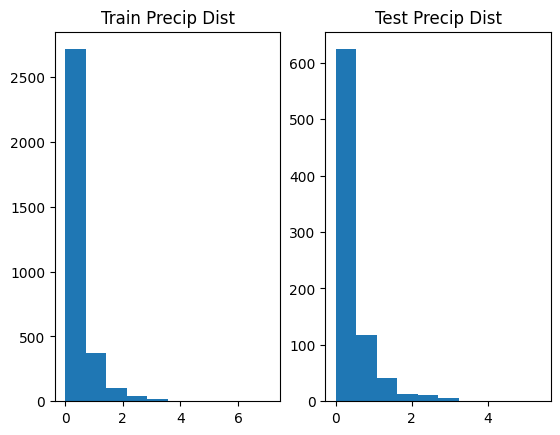

{'fit_intercept': True, 'positive': False}
Val score = 0.26184264572943755, Test score = 0.5065033206453365


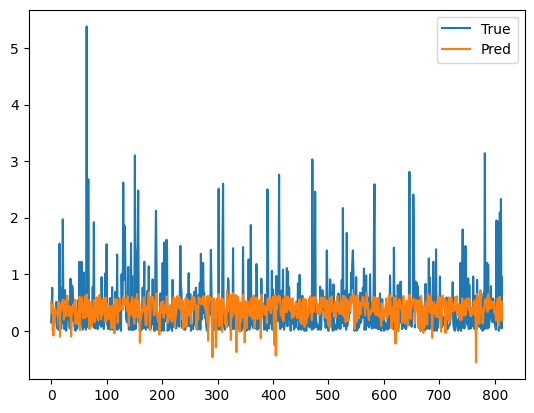

In [48]:
"""
Although the error metric was low, the predictions are not
useful, as seen from the plots. It simply predicts between
0 and 0.3 which minimizes the error but does not exactly 
capture the entire spread of the data.

This is likely due to the fact that there are many more
days without rain, than days with any rain. We can try
to change this by removing some of the days without rain
to balance out the distribution and bit more.
"""
x_cols = ['vpd_min', 'vapor_dew_ratio', 'dewpoint', 
          'vpd_max', 'min_temp', 'month']
target = "precip"
df = pd.read_csv("rain.csv")
no_precip = df[df['precip'] == 0].shape[0]
n_remove = 11000
df1 = df[df["precip"] == 0.0].reset_index().loc[n_remove:,:]
target_min = 0.01
df2 = df.loc[df['precip'] > target_min,:]
df = pd.concat([df1,df2], ignore_index=True)
print(f"Samples without precip {df[df['precip'] == 0].shape[0]}")
print(f"Samples with precip {df[df['precip'] > 0.0].shape[0]}")
df.loc[:,x_cols] = StandardScaler().fit_transform(df[x_cols])
print(df[x_cols+[target]].corr()[target])
x_train, x_test, y_train, y_test = train_test_split(df[x_cols], df[target], test_size=0.2, 
                                                    stratify=df["precip_level"], random_state=123)

# verifying the distribution of precip
plt.subplot(1,2,1)
plt.hist(y_train)
plt.title("Train Precip Dist")
plt.subplot(1,2,2)
plt.hist(y_test)
plt.title("Test Precip Dist")
plt.show()

paramset = {"fit_intercept": [False,True], "positive": [False,True]}
lm, params = fit_and_eval_model(x_train, y_train, x_test, y_test, 
                                LinearRegression(), paramset)

Samples without precip 1252
Samples with precip 4088
Epoch 1/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1180 - val_loss: 0.0989
Epoch 2/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0985 - val_loss: 0.0906
Epoch 3/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0921 - val_loss: 0.0882
Epoch 4/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0843 - val_loss: 0.0874
Epoch 5/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0868 - val_loss: 0.0871
Epoch 6/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0873 - val_loss: 0.0863
Epoch 7/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0847 - val_loss: 0.0861
Epoch 8/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.0884 - val_loss: 0.0860
Epoch 9/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0850 - val_loss: 0.0862
Epoch 10/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0780 - val_loss: 0.0859
Epoch 11/15
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.076

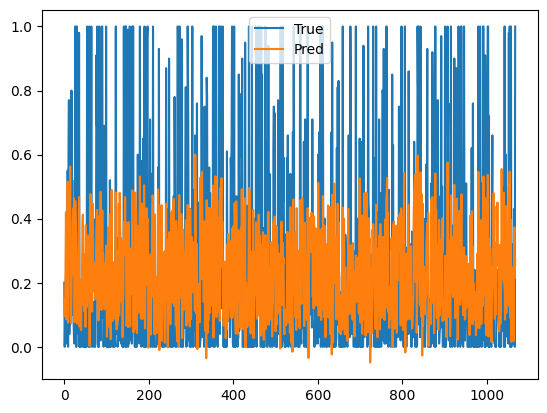

In [49]:
"""
Given that the linear models are not doing well, but are also
not so much overfitting, we can try a more complex model. We 
will try a simple fully-connected neural network in order to 
learn more complex relationships.
"""
import keras

def build_model(units, n_layers, dropout):
    model = keras.Sequential()
    for _ in range(n_layers-1):
        model.add(keras.layers.Dense(units=units, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(units=units, activation="relu"))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=keras.optimizers.Nadam(learning_rate=0.0001))
    return model

x_cols = ['vpd_min', 'vapor_dew_ratio', 'dewpoint', 
          'vpd_max', 'min_temp', 'jul_day']
target = "precip"
df = pd.read_csv("rain.csv")
no_precip = df[df['precip'] == 0].shape[0]
n_remove = 10000
df1 = df[df[target] == 0.0].reset_index().loc[n_remove:,:]
target_min = 0.0
target_max = 1.0
df2 = df.loc[df[target] > target_min,:]
df2.loc[:,target] = df[target].clip(upper=target_max)
df = pd.concat([df1,df2], ignore_index=True)
print(f"Samples without precip {df[df['precip'] == 0].shape[0]}")
print(f"Samples with precip {df[df['precip'] > 0.0].shape[0]}")
df.loc[:,x_cols] = StandardScaler().fit_transform(df[x_cols])
x_train, x_test, y_train, y_test = train_test_split(df[x_cols], df[target], test_size=0.2, 
                                                    stratify=df["precip_level"], random_state=123)

neuralnet = build_model(32, 4, 0.05)
val_index = int(0.8*x_train.shape[0])
x_val = x_train[val_index:]
y_val = y_train[val_index:]
x_train = x_train[:val_index]
y_train = y_train[:val_index]
neuralnet.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))
y_pred = neuralnet.predict(x_test)
y_pred = y_pred.reshape((y_pred.shape[0],))
test_err = mean_squared_error(y_test, y_pred)
print(f"Test Err = {test_err}")
x = list(range(x_test.shape[0]))
plt.plot(x, y_test, label="True")
plt.plot(x, y_pred, label="Pred")
plt.legend()
plt.show()

month                  -0.003307
jul_day                -0.003978
day                    -0.003988
quarter                -0.004835
mean_temp               0.016292
abs_year               -0.027424
year                   -0.027424
abs_month              -0.027494
abs_week               -0.027511
abs_day                -0.027511
abs_quarter            -0.027536
day_in_quarter          0.034200
prev_max_temp           0.038456
max_temp               -0.043894
prev_adj_vpd_max       -0.053967
prev_vpd_range         -0.055746
prev_adj_vpd_min       -0.057976
prev_vpd_max           -0.061520
prev_vpd_mean          -0.064898
prev_vpd_min           -0.069424
min_temp                0.078416
prev_mean_temp          0.079419
prev_min_temp           0.119072
prev_vapor_dew_ratio   -0.136329
prev_dewpoint           0.154123
dewpoint                0.180423
vpd_range              -0.185813
adj_vpd_max            -0.208543
vpd_max                -0.208603
vpd_mean               -0.222420
vpd_min   

C:\Users\asaph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


{'C': 1.0257307692307693, 'penalty': 'l1'}
Val acc = 0.8081001631651719, Test acc = 0.8132333767926988
Test MAE = 0.28448325099309063


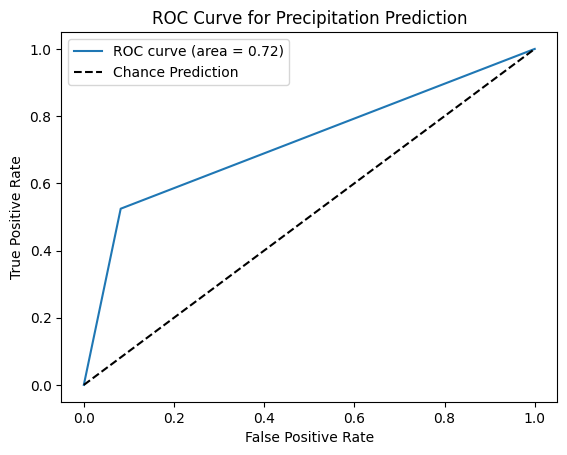

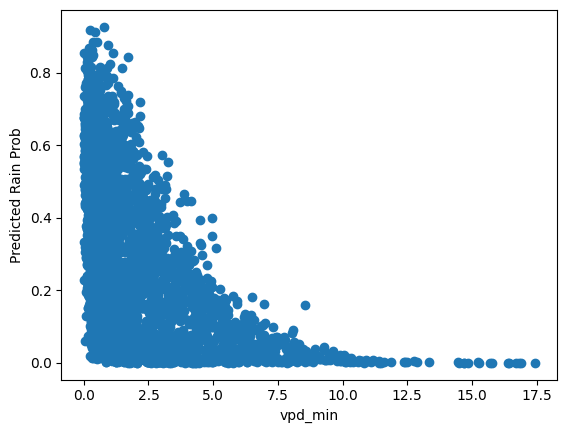

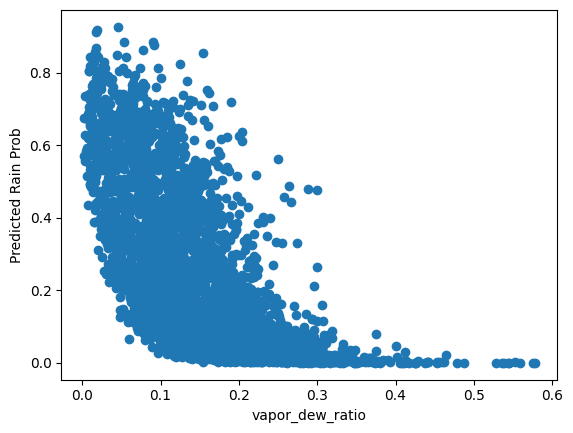

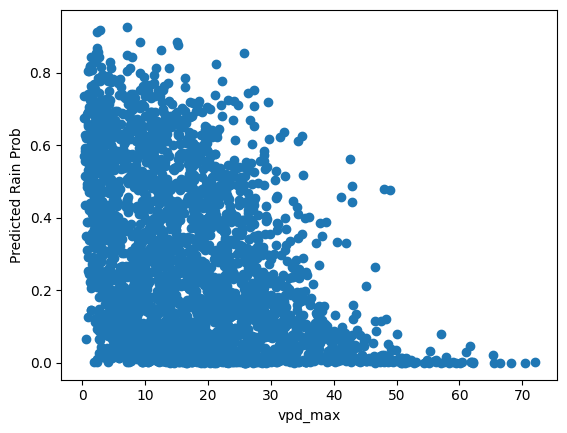

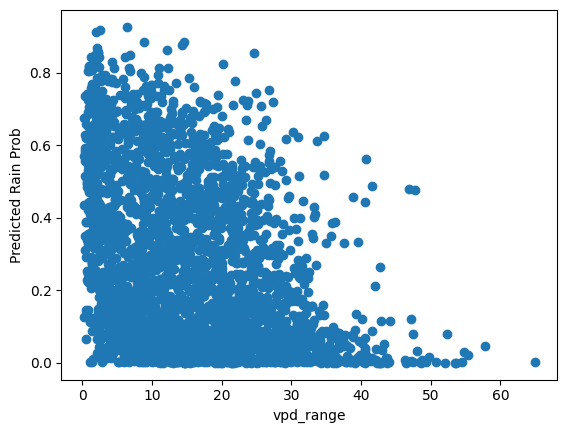

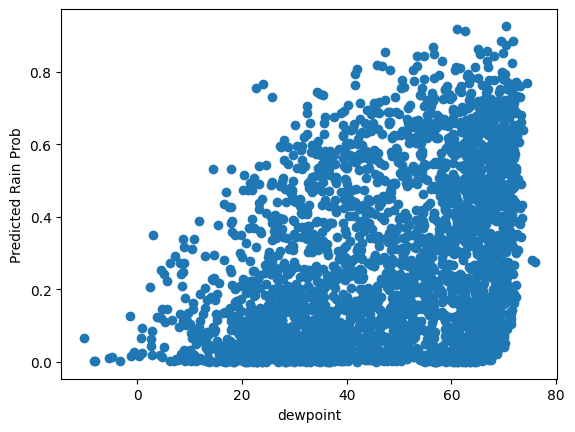

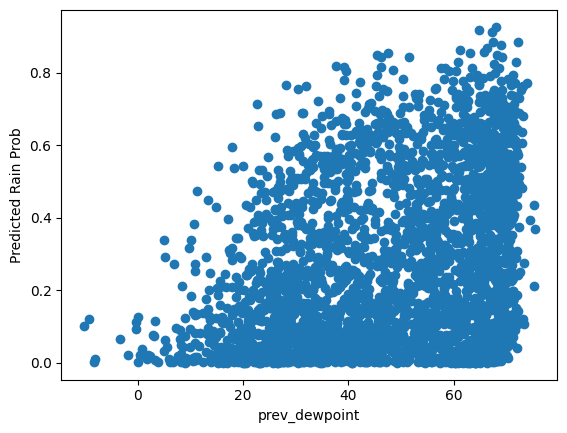

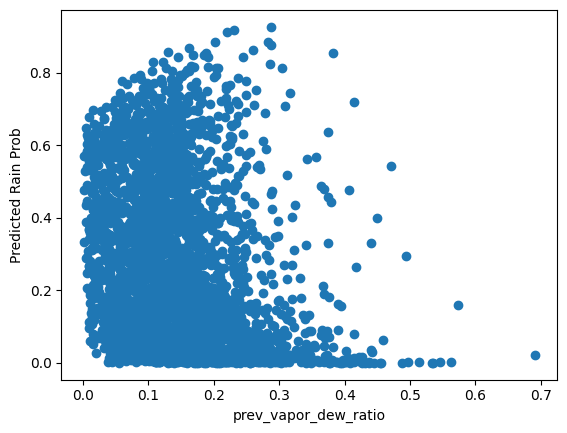

In [62]:
"""
After some tuning and data wrangling, we can get some
better results with the neural network. However, these
results are not very useful. The model is generally
predicting around the mean with little variation. The
main reason for this is the type of data that we have.
We have daily precipitation totals over 41 years, which
means most of the target values are 0, as most days it
does not rain. When the target is not 0, it is usually
still very low because when it does rain, there will
not be much rain accumulated in a day. The times when 
the precipitation total for a day is > 2 in are few
and far between. This is why most of the models do
not rpedict well and are not actually good models of
the phenomena.

What we can do is try to switch our target. One thing we
can do is switch to a classification problem. We can label
the target as rain = [0,1] for when it rains and when it
does not. We can then use something like LogisticRegression
to predict the probability of [0,1] which would equate to
the probability of precipitation.
"""

def plot_roc(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred) 
    roc_auc = auc(fpr, tpr)
    plt.figure()  
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance Prediction')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Precipitation Prediction')
    plt.legend()
    plt.show()

df = pd.read_csv("rain.csv")
target = "precip"
df.loc[:,"precip_total"] = df["precip"]
df.loc[:,"precip"] = (df["precip_total"] > 0).astype(int)

# now we need to see which features are good for
# predicting precip prob
exclude = ["precip_total","log_precip","sqrt_precip","precip^2","inv_precip","precip_level"]
cols = [c for c in df.columns.values if c not in exclude]
print(df[cols].corr().sort_values(target, key=abs)[target])

def fit_and_eval_log_reg(df, x_cols, score, max_iter=1000):
    # select the features we want, split the data
    # for train and eval
    params = {"C": np.linspace(1e-4,10.0,40), "penalty": ["l1","l2"]}
    grid = GridSearchCV(LogisticRegression(solver="liblinear", 
                                        max_iter=max_iter, n_jobs=-1),
                        param_grid=params, cv=5, scoring=score, n_jobs=-1,
                        verbose=3)
    scaler = StandardScaler()
    df.loc[:,x_cols] = scaler.fit_transform(df[x_cols])
    x_train, x_test, y_train, y_test = train_test_split(df[x_cols], df[target], test_size=0.2, 
                                                        stratify=df[target], random_state=123)
    grid.fit(x_train, y_train)
    val_score = grid.best_score_
    y_pred = grid.best_estimator_.predict(x_test)
    y_pred_prob = grid.best_estimator_.predict_proba(x_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_logloss = log_loss(y_test, y_pred_prob)
    mae = mean_absolute_error(y_test, y_pred_prob[:,1])
    print(grid.best_params_)
    if score == "neg_log_loss":
        print(f"Val log loss = {-1*val_score}, Test log loss = {test_logloss}")
    else:
        print(f"Val acc = {val_score}, Test acc = {test_acc}")
    print(f"Test MAE = {mae}")
    plot_roc(y_test, y_pred)
    x_test = scaler.inverse_transform(x_test)
    for i, c in enumerate(x_cols):
        plt.scatter(x_test[:,i],y_pred_prob[:,1])
        plt.xlabel(c)
        plt.ylabel("Predicted Rain Prob")
        plt.show()

x_cols = ["vpd_min","vapor_dew_ratio","vpd_max","vpd_range","dewpoint","prev_dewpoint","prev_vapor_dew_ratio"]
fit_and_eval_log_reg(df, x_cols, "accuracy", max_iter=int(1e9))

precip
0.0    4088
1.0    4088
Name: count, dtype: int64
Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'C': 1.0257307692307693, 'penalty': 'l1'}
Val acc = 0.6200305810397554, Test acc = 0.6210268948655256
Test MAE = 0.46101208358954165


C:\Users\asaph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


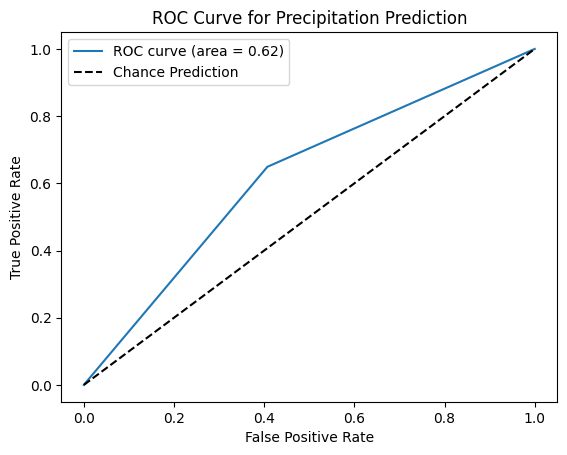

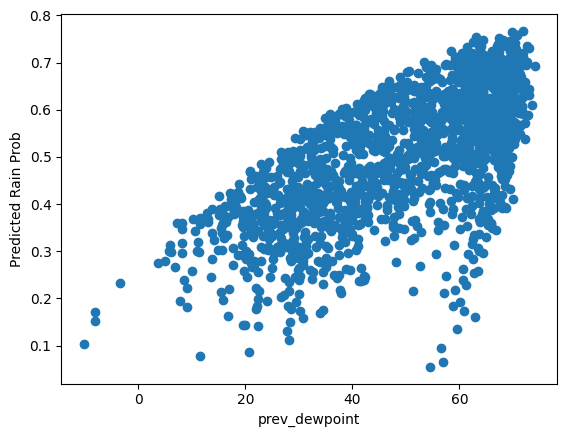

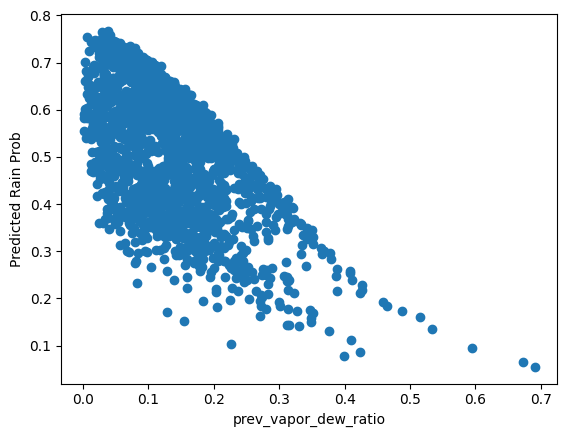

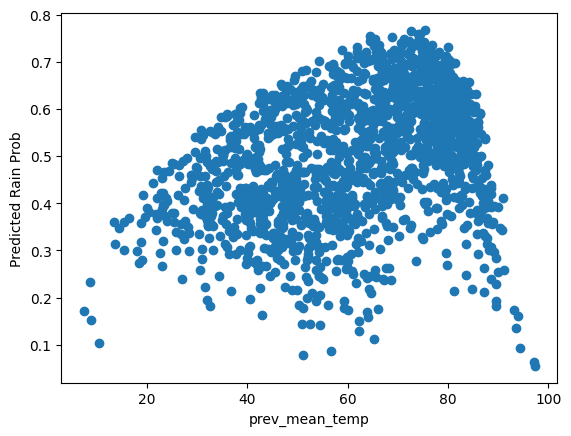

In [65]:
"""
The above results are good, and they prove that the model is
a good predictor of the rain probability. We could maybe make
it better by using something like SGDClassifier with log loss,
or even a neural network like we did a few cells above. However,
for the sake of usability, what I want to look at next is a model
that only uses information from the previous day. That is, if
I really want to predict the probability of rain tomorrow, I
likely would not have the VPD and dewpoint information, at best
these would be guesses. But I can look up that information for
the previous day (I did it myself to make sure). Temperatures
are easy to find, as well as dewpoint and relative humidity. We
can use the previous data to calculate VPD as well as the other
features used below.
"""
df = pd.read_csv("rain.csv")
target = "precip"
df.loc[:,"precip_total"] = df["precip"]
df.loc[:,"precip"] = (df["precip_total"] > 0).astype(int)
rem_zeros = 7164
n_zeros = df[df[target] == 0].shape[0]
drop_indexes = [list(df[df[target] == 0].index)[i] for i in np.linspace(0, n_zeros, rem_zeros, endpoint=False, dtype=int)]
df = df.drop(drop_indexes, axis=0)
print(df[target].value_counts())
x_cols = ["prev_dewpoint","prev_vapor_dew_ratio","prev_mean_temp"]
fit_and_eval_log_reg(df, x_cols, "accuracy", max_iter=int(1e9))

Discussion
-------------

Based on the analysis and experiments performed, we were not able to confidently model daily rain totals as a function of the information gathered from PRISM. To be clear PRISM is not claiming that this is possible, they simply have the information available. Just out of curiosity I generated a dataset on their website with as many years and as many parameters as they had for Oklahoma County. The main goal was to demonstrate my data analysis and modelling process.

There were still significant insights gathered through this process. These are summarized below:

1. There seems to be an increase in the maximum amount of rain in a single day, in the last 15 years for Oklahoma County. From 2010 to 2021 there were three instances of single days with 5+ inches of rain. The last instance before 2010 was in 1983. Refer to the Time Series Analysis section at the top for more detail.

2. We can also conclude that the amount and chance of precipitation for Oklahoma County has some dependence on how much precipitation occurred in the previous day. Refer to the Time Series Analysis section at the top for more detail.

2. The calendar time seems to have very little correlation as to whether any given day will have precipitation in Oklahoma County, as well as the chance of precipitation for any given day. This was very surprising to me as a resident, considering May to July is known as the "rainy" season. Also, April to June are the tornado season, which is always full of rainy days. However, this dataset count total precipitation, which is rain and melting snow. This means that the colder months of October to January also play a role. The best predictor of precipitation from the calendar was the "day_in_quarter" which counts from 0 to 91 from the begining to end of each quarter of the year. However, this calendar feature only had about 0.01 correlation, so it was not used.

Models
------------

Ultimately, we were able to fit a good model to the data by shifting our target from daily precipitation totals, to simply predicting the precipitation probability. This proved to be a much better approach, as the best model was a LogisticRegression which predicted the presence or absence of precipitation with 82% accuracy. This means that 82% of the time, in testing, it predicted exactly whether or not there was precipitation. The test Mean Absolute Error (MAE) was bout 0.28, which that even when it predicted incorrectly, it was still within 30% chance. In other words, for the days when it rains, on average it predicts $\geq$ 72% chance. On the days when it does not rain, it predict $\leq$ 28% chance on average. This is a very good model for precipitation in Oklahoma County.

Given that the model is good, we can draw good conclusions from it. Mainly we can say that vapor_dew_ratio is a great predictor for rain. This is a feature derived from the dataset which is equal to $\dfrac{VPD_{mean}}{dewpoint}$ where the mean Vapor Pressure Deficit (VPD) for the day is $\dfrac{VPD_{min} + VPD_{max}}{2}$ . Although we cannot infer which is the cause and which is the effect, one certainly affects the other. Specifically, we can say that when vapor_dew_ratio $\geq$ 0.4, there is very little ( $\lt$ 5% ) chance of precipitation. On the other hand, as the ratio is lower and apporaching 0.02, it becomes more likely that there will be precipitation than not.

Although the model is good, there is one major flaw in its design: the fact that it uses VPD and dewpoint from the day which is being predicted. This information would be impossible to know before the fact, as these data would be predictions themselves. Therefore, beyond analysis, this model is only usable in a very specific case where we know the VPD and dewpoint for a specific day but we did not record whether or not there was precipitation.

To address this issue, I created a new model which predicts the same thing, but it only uses information from the previous day. This was possible due to our insight that precipitation has some significant autocorrelation with 1 day lag. This second model was not as accurate as the first. It predicts exactly whether or not there will be precipitation on a given day with 62% accuracy. The test MAE is 0.46, which means that when it does rain, the model likely predicts $\geq$ 54% chance. On the other hand the model likely predicts $\leq$ 46% chance when it does not rain. Although not as good, this model is a lot more useful than the previous one, as it only requires the dewpoint, mean temperature, and mean relative humidity (RH) of the previous day. These can be taken from websites of weather stations or the National Weather Service (NWS) [2].

With mean RH, we can calculate vpd_mean as $VPD_{mean} = 610.78e^{\frac{17.2694T}{T +237.3}} \times (1 - RH/100.0)$ [3] where T is the mean temperature then vapor_dew_ratio is simply $\dfrac{VPD_{mean}}{dewpoint}$.

References
--------------

[1] “PRISM Climate Group at Oregon State University.” https://prism.oregonstate.edu/explorer/
\
[2] NOAA’s National Weather Service, “National Weather Service.” https://forecast.weather.gov/data/obhistory/KTIK.html
\
[3] P. Koverda, “The Ultimate Vapor Pressure Deficit (VPD) guide,” Pulse Grow, Feb. 12, 2020. https://pulsegrow.com/blogs/learn/vpd